In [10]:
"""
This code automatically downloads the MNIST dataset and creates a custom dataset with colorized images.
A ResNet18 model is used to extract features from the images, which are then saved to disk.
"""

import os.path
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from tqdm import tqdm


# Helper function to convert grayscale image to red or green
def colorize(image, color):
    colored_image = torch.zeros(3, 28, 28)  # Create an image with 3 channels (RGB)
    if color == 'red':
        colored_image[0] = image  # Red channel
    elif color == 'green':
        colored_image[1] = image  # Green channel
    else:
        colored_image[2] = image
    return colored_image


# Creating the custom dataset
class CustomMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, digit = self.mnist_dataset[idx]

        # Colorize the image
        color_random = np.random.rand()
        if color_random < 0.3:
            color = 'red'
        elif color_random < 0.6:
            color = 'green'
        else:
            color = 'blue'
        colored_image = colorize(image.squeeze(), color)  # Remove channel dimension of the grayscale image
        # colored_image = image
        # Create the concept label
        concept_label = np.zeros(12)  # 10 digits + 2 colors
        concept_label[digit] = 1
        concept_label[10] = 1 if color == 'red' else 0
        concept_label[11] = 1 if color == 'green' else 0

        # Create the target label
        target_label = 1 if digit % 2 == 0 else 0

        return colored_image, torch.tensor(concept_label, dtype=torch.float32), torch.tensor(target_label, dtype=torch.float32)

def main():
    # Step 1: Prepare the MNIST dataset
    # [Include the CustomMNISTDataset class from the previous code snippet here]

    # Load MNIST data
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


    # Create custom datasets
    custom_train_dataset = CustomMNISTDataset(mnist_train)
    custom_test_dataset = CustomMNISTDataset(mnist_test)

    # DataLoaders
    train_loader = DataLoader(custom_train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(custom_test_dataset, batch_size=64, shuffle=False)

    # Step 2: Prepare ResNet18 model for feature extraction
    model = models.resnet18(pretrained=True)
    model.eval()  # Set the model to evaluation mode

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    model = model.to(device)

    # Step 3: Extract features
    def extract_features(data_loader):
        features = []
        concept_labels = []
        task_labels = []

        with torch.no_grad():
            for imgs, concepts, tasks in tqdm(data_loader):
                imgs = imgs.to(device)
                out = model(imgs)
                features.append(out.cpu().numpy())
                concept_labels.append(concepts.numpy())
                task_labels.append(tasks.numpy())

        return np.concatenate(features), np.concatenate(task_labels)

    train_features, train_tasks = extract_features(train_loader)
    test_features, test_tasks = extract_features(test_loader)
    return train_features, train_tasks, test_features, test_tasks





In [11]:
main()

100%|██████████| 157/157 [00:02<00:00, 65.20it/s]


In [12]:
    # Load MNIST data
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


    # Create custom datasets
    custom_train_dataset = CustomMNISTDataset(mnist_train)
    custom_test_dataset = CustomMNISTDataset(mnist_test)

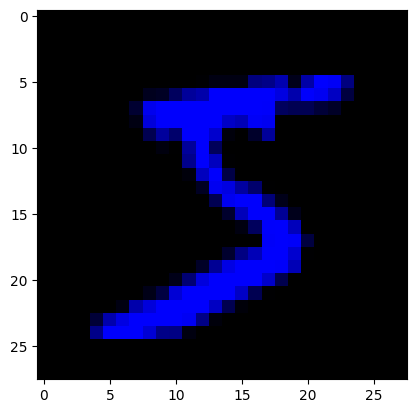

In [13]:
# show one image
import matplotlib.pyplot as plt
image, concept, target = custom_train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
